### Johnny Depp vs Amber Heard Sentiment Analysis

----------------------------------------------------------------------------------------------------------------------

### Twitter section

##### Scrape relevant tweets given search, limit, and date parameters

In [65]:
import snscrape.modules.twitter as sntwitter
import csv

maxTweets = 500000

#Open/create a file to append data to
csvFile = open('place_result.csv', 'a', newline='', encoding='utf8')

#Use csv writer
csvWriter = csv.writer(csvFile)
csvWriter.writerow(['id','date','tweet',]) 

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('johnnydepp + since:2022-04-01 until:2022-06-03 lang:en -filter:links -filter:replies').get_items()):
        if i > maxTweets :
            break
        csvWriter.writerow([tweet.id, tweet.date, tweet.content])

csvFile.close()

##### Read scraped tweets into pandas dataframe. Convert Date column to datetime object and remove timestamp element

In [174]:
import pandas as pd

df = pd.read_csv('place_result.csv', parse_dates=True)

df['date'] = pd.to_datetime(df['date'])

df['date'] = df['date'].dt.date

##### Create function for cleaning each tweet so they are more likely to be classified by the NLP model. Call this function on the dataframe to create new 'cleaned_tweet' column

In [176]:
import re

def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = tweet.lower()
    return tweet

df['cleaned_tweet'] = df['tweet'].apply(cleaner)

df.head()

,id,date,tweet,cleaned_tweet
0,1532512347192950802,2022-06-02,I’m not sure what happened with the ‘case’ but...,i’m not sure what happened with the ‘case’ but...
1,1532512214577446921,2022-06-02,I’m sorry.. weren’t you all dick riding Johnny...,i’m sorry.. weren’t you all dick riding johnny...
2,1532512185028575247,2022-06-02,The Michael Sussman trial was more important t...,the michael sussman trial was more important t...
3,1532512156641808384,2022-06-02,"I will keep watching #AmberHeard movies, she n...","i will keep watching amberheard movies, she ne..."
4,1532512100404195328,2022-06-02,Amber Heard subverted the rules of wokeness to...,amber heard subverted the rules of wokeness to...


##### Import the NLTK library with the SentimentIntensityAnalyzer (SID) module. Add custom words to the model to help it classify positive/negative hashtags. Run the sentiment analysis and add the resulting sentiment scores to the dataframe. Create function for designating sentiment scores as positive/negative/neutral and apply this to the dataframe creating a new column called 'Sentiment Category'

In [177]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

add_words = {'justiceforjohnny':1,'amberturd':1,'justiceforjohnnydepp':1,'johnnydeppdeservesjustice':1,
            'amberheardisaliar':1,'amberheardisapsycopath':1,'amberheardisanabuser':1,'westandwithjohnnydepp':1,'johnnydeppisinnocent':1,'istandwithjohnnydepp':1,'webelieveyoujohnny':1,
            'wearewithyoujohnnydepp':1,'weloveyoujohnnydepp':1}

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
sid.lexicon.update(add_words)

sent_score_list = []
for tweet in df['cleaned_tweet']:
    sent_score_list.append((sid.polarity_scores(str(tweet)))['compound'])

df['Sentiment Score'] = pd.Series(sent_score_list)

def sentiment_category(sentiment_score):
    if(sentiment_score>0):
        label = 'positive'
    elif(sentiment_score == 0):
        label = 'neutral'
    else:
        label = 'negative'
    return(label)

df['Sentiment Category'] = df['Sentiment Score'].apply(sentiment_category)

df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dfreely001\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,date,tweet,cleaned_tweet,Sentiment Score,Sentiment Category
0,1532512347192950802,2022-06-02,I’m not sure what happened with the ‘case’ but...,i’m not sure what happened with the ‘case’ but...,0.3546,positive
1,1532512214577446921,2022-06-02,I’m sorry.. weren’t you all dick riding Johnny...,i’m sorry.. weren’t you all dick riding johnny...,-0.5204,negative
2,1532512185028575247,2022-06-02,The Michael Sussman trial was more important t...,the michael sussman trial was more important t...,0.1397,positive
3,1532512156641808384,2022-06-02,"I will keep watching #AmberHeard movies, she n...","i will keep watching amberheard movies, she ne...",-0.1027,negative
4,1532512100404195328,2022-06-02,Amber Heard subverted the rules of wokeness to...,amber heard subverted the rules of wokeness to...,-0.9022,negative


##### Create new dataframes separating positive and negative sentiments and grouping each by date

In [178]:
neg_sentiment = df[df['Sentiment Category'] == 'negative']
neg_count_df = neg_sentiment.groupby(['date'],as_index=False).count()

pos_sentiment = df[df['Sentiment Category'] == 'positive']
pos_count_df = pos_sentiment.groupby(['date'],as_index=False).count()

##### Plot positive vs negative tweet count over the time period of the trial. The visualisation shows spikes in the amount of tweets on key days of the trial (e.g. when Johnny Depp first took the stand - 19/04, when Amber Heard first took the stand - 04/05 , and when the final outcome was read out in court - 01/06). Interestingly, tweets only started to significantly trend more positively in support of Johnny Depp towards the end of the trial when Amber Heard began to be cross examined on 17/05

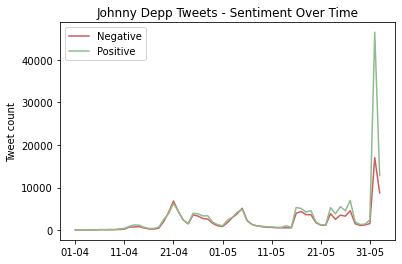

In [179]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(neg_count_df['date'], neg_count_df['tweet'], color='IndianRed', label='Negative')
plt.plot(pos_count_df['date'], pos_count_df['tweet'], color='DarkSeaGreen', label='Positive')
ax.set_xticks(neg_count_df['date'][::10])
ax.set_xticklabels([str(x)[-2:] + '-' + str(x)[5:7] for x in neg_count_df['date'][::10]])
plt.title('Johnny Depp Tweets - Sentiment Over Time')
plt.ylabel('Tweet count')
plt.legend(loc='upper left')
plt.show()

##### Plot bar chart showing the overall ratio and count of positive vs negative tweets for the extracted time period (01/04 - 03/06)

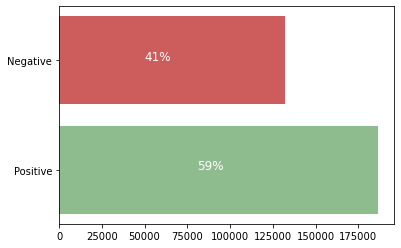

In [180]:
barh_x = ['Positive', 'Negative']
barh_y = [len(pos_sentiment), len(neg_sentiment)]

neg_percent = (barh_y[1] / sum(barh_y))*100
pos_percent = (barh_y[0] / sum(barh_y))*100


plt.figure()
plt.barh(barh_x, barh_y, color=['DarkSeaGreen', 'IndianRed'])

plt.text(50000, 1, str('{:.0f}'.format(neg_percent) + '%'), color='white', fontsize='large')
plt.text(81000, 0.01, str('{:.0f}'.format(pos_percent) + '%'), color='white', fontsize='large')

plt.show()

##### Create wordcloud to highlight the most prominent positive words used in tweets

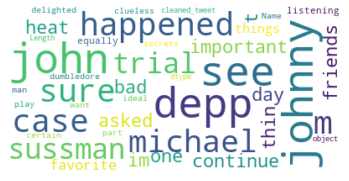

In [181]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(pos_sentiment['cleaned_tweet']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Create wordcloud to highlight the most prominent negative words used in tweets

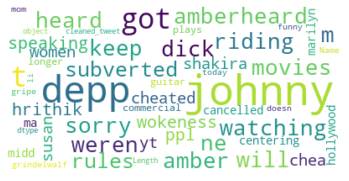

In [182]:
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(neg_sentiment['cleaned_tweet']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Youtube section

In [183]:
from googleapiclient.discovery import build

api_key = 'xxx'

##### Create a YouTube API connection / server

In [184]:
youtube = build('youtube', 'v3', developerKey=api_key)

##### Function for grabbing youtube video ids given search field parameter

In [185]:
def get_video_ids(youtube, **kwargs):

    video_id_lst = []

    video_response=youtube.search().list(
        part="snippet",
        **kwargs
        ).execute()
    
    video_details_lst = video_response.get('items')
    
    for detail in video_details_lst:
        video_id_lst.append(detail['id']['videoId'])

    return video_id_lst


##### Function for grabbing comments of YouTube video using video ID. Note this function purposefly only scrapes original comments (not replies to comments) and stops after scraping 5 pages.

In [186]:
def video_comments(video_id):

    run_counter = 0
    comments_lst= []
  
    # retrieve youtube video results
    video_response=youtube.commentThreads().list(
        part='snippet,replies',
        videoId=video_id
        ).execute()

    # iterate video response
    while run_counter <= 5:
        
        # extracting required info
        for item in video_response['items']:
            
            # Extracting comments
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
  
            # append comment to list
            comments_lst.append(comment)
  
        # Repeat until comments have 
        if 'nextPageToken' in video_response:
            run_counter += 1

    return comments_lst

##### Call previous functions to scrape youtube comment data given relevant search field and a max result limit

In [187]:
yt_search = 'Johnny Depp testifies'

JD_ids = get_video_ids(youtube, q=yt_search, maxResults=5)

JD_comments = []

for id in JD_ids:
    JD_comments.append(video_comments(id))

##### Import the NLTK library with the SentimentIntensityAnalyzer (SID) module. Run the sentiment analysis and add the resulting sentiment scores to the dataframe. Call the previously created function for designating sentiment scores as positive/negative/neutral and apply this to the dataframe creating a new column called 'Sentiment Categorisation'

In [188]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import pandas as pd

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


nltk.download('words')
words = set(nltk.corpus.words.words())

JD_comments_merge = [item for sublist in JD_comments for item in sublist]

yt_compound_scores = []
for comment in JD_comments_merge:
    comment = cleaner(comment)
    yt_compound_scores.append((sid.polarity_scores(str(comment)))['compound'])

yt_comments_category = []
for score in yt_compound_scores:
    yt_comments_category.append(sentiment_category(score))

zipped = zip(JD_comments_merge, yt_compound_scores, yt_comments_category)

df_yt = pd.DataFrame([i for i in zipped], columns=['YT Comment', 'Compound Score', 'Sentiment Categorisation'])
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dfreely001\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dfreely001\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


##### Create wordcloud to highlight the most prominent negative words used in youtube comments

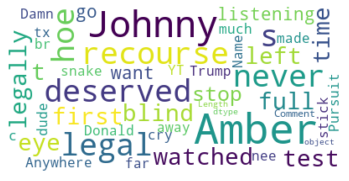

In [189]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

yt_neg_df = df_yt[df_yt['Sentiment Categorisation'] == 'negative']

wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(yt_neg_df['YT Comment']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Create wordcloud to highlight the most prominent positive words used in youtube comments

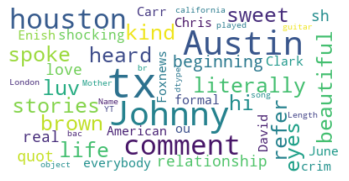

In [190]:
yt_pos_df = df_yt[df_yt['Sentiment Categorisation'] == 'positive']

wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(str(yt_pos_df['YT Comment']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()